#Miniproject D7041E, Applied Artificial Intelligence

##prerequisite 
In the following steps we load in the dataset from kaggle and run some tests to make sure it works correctly

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                 5MB  2022-11-13 15:47:17          14434        413  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india    Credit Card Spending Habits in India           319KB  2022-12-14 07:30:37           1270         49  1.0              
michals22/coffee-dataset                                        Coffee dataset                                  24KB  2022-12-15 20:02:12           3425         77  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce Sales Data

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

100% 3.74G/3.75G [00:24<00:00, 187MB/s]
100% 3.75G/3.75G [00:24<00:00, 164MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip

Import all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models, losses
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

In [ ]:
df_train = pd.read_csv('train.csv',index_col=0)
df_val = pd.read_csv('valid.csv',index_col=0)
df_test = pd.read_csv('test.csv',index_col=0)

In [ ]:
path = 'real_vs_fake/real-vs-fake/'
imageGen = ImageDataGenerator(rescale=1./255., 
                              featurewise_center=True, 
                              featurewise_std_normalization=True)

In the following cell we print out some of images that it has to make sure that we import the data correctly

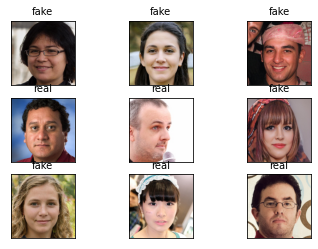

In [ ]:
for i in range(9):
    random = np.random.randint(1,len(df_train['path'].values))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(path + df_train['path'].values[random]))
    plt.title(df_train['label_str'].values[random], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

Load in the images in to a ImageDataGenerator from a directory where it separates the folders in to separate classes. In this case it woud be real and fake but we desided to make binary separation (0 and 1).

As the images in theis dataset har of size 256x256 we resize them to 32x32 to send them in to our model and we also specify the batch size here.

In [ ]:
trainGen = imageGen.flow_from_directory(
    path + 'train/',
    target_size=(32, 32),
    batch_size=96,
    color_mode='grayscale',
    class_mode='binary'
)
testGen = imageGen.flow_from_directory(
    path + 'test/',
    target_size=(32, 32),
    batch_size=96,
    color_mode='grayscale',
    class_mode='binary',
    shuffle = False
)
validGen = imageGen.flow_from_directory(
    path + 'valid/',
    target_size=(32, 32),
    batch_size=96,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In the below we build our model, in this case LeNet. LeNet is one of the first CNN models and were used to recognize the handwritten numbers, it has 7 layers  were three of are convolutional layers, two average-pooling layers and two fully connected layers.

**Configuration:**
> Activation function: tanh, sigmoid

> Cost function: crossentropy

> Optimization function: Adam

In [ ]:
class LeNet(Sequential):
    def __init__(self, input_shape, nb_classes, opt='adam'):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding="same"))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='tanh'))
        self.add(Dense(84, activation='tanh'))
        self.add(Dense(nb_classes, activation='sigmoid'))

        self.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model = LeNet((32,32,1), 1)
model.summary()

Model: "le_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_4 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 120)               692

##First try

###Model training
Here we train the above created model with our training data and we do it by running the training backpropagate and run again to improve the results, we do so several times (epoch) in this case we train it 40 times over. 

After every iteration the accuracy on traning and validation data are calculated.

In [ ]:
history = model.fit_generator(
    trainGen,
    steps_per_epoch = (100000//96),
    validation_data = validGen,
    validation_steps = (20000//96),
    epochs = 40
)

<ipython-input-28-16e40f135953>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
1041/1041 [==============================] - 364s 349ms/step - loss: 0.6151 - accuracy: 0.6605 - val_loss: 0.6008 - val_accuracy: 0.6751
Epoch 2/40
1041/1041 [==============================] - 286s 275ms/step - loss: 0.5941 - accuracy: 0.6825 - val_loss: 0.5889 - val_accuracy: 0.6868
Epoch 3/40
1041/1041 [==============================] - 283s 272ms/step - loss: 0.5849 - accuracy: 0.6915 - val_loss: 0.5866 - val_accuracy: 0.6906
Epoch 4/40
1041/1041 [==============================] - 282s 271ms/step - loss: 0.5795 - accuracy: 0.6956 - val_loss: 0.5831 - val_accuracy: 0.6938
Epoch 5/40
1041/1041 [==============================] - 313s 300ms/step - loss: 0.5755 - accuracy: 0.6992 - val_loss: 0.5823 - val_accuracy: 0.6908
Epoch 6/40
1041/1041 [==============================] - 303s 291ms/step - loss: 0.5687 - accuracy: 0.7037 - val_loss: 0.5746 - val_accuracy: 0.6990
Epoch 7/40
1041/1041 [==============================] - 311s 299ms/step - loss: 0.5565 - accuracy: 0.7138 - val_

###Plot on results
We make a plot on the accuracy and loss over every epoch

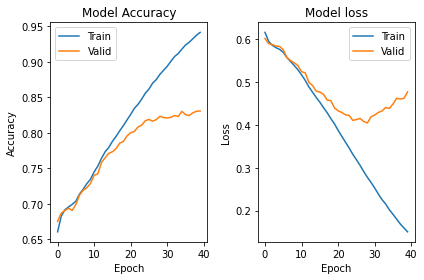

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history["accuracy"])
ax1.plot(history.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

###Prediction on the Test data

In [ ]:
xTest = model.predict(testGen)
yTest = testGen.classes

209/209 [==============================] - 47s 220ms/step


### Confusion Matrix

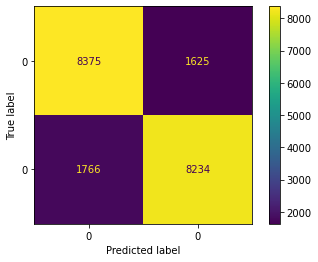

In [ ]:
cm = confusion_matrix(yTest, xTest.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=yTest)
disp.plot()
plt.show()

In [ ]:
print("ROC-AUC Score:", roc_auc_score(yTest, xTest))
print("AP Score:", average_precision_score(yTest, xTest))

ROC-AUC Score: 0.9085494599999999
AP Score: 0.9056067296732019


###Test results

In [ ]:
print(classification_report(yTest, xTest > 0.5))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83     10000
           1       0.84      0.82      0.83     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



##Optimizer mini-batch GD

###Adapt the data
In this run we use different optimizer, mini-batch gradient descent and as the name suggests it operates with small batch sizes. hence in the following cell we change the batch size.

In [ ]:
trainGen = imageGen.flow_from_directory(
    path + 'train/',
    target_size=(32, 32),
    batch_size=25,
    color_mode='grayscale',
    class_mode='binary'
)
testGen = imageGen.flow_from_directory(
    path + 'test/',
    target_size=(32, 32),
    batch_size=25,
    color_mode='grayscale',
    class_mode='binary',
    shuffle = False
)
validGen = imageGen.flow_from_directory(
    path + 'valid/',
    target_size=(32, 32),
    batch_size=25,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


###Model

**Configuration:**
> Activation function: tanh, sigmoid

> Cost function: crossentropy

> Optimization function: mini-batch gradient descent 

In [ ]:
model = LeNet((32,32,1), 1,'SGD')
model.summary()

Model: "le_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 120)               692

###Model training

In [ ]:
history = model.fit_generator(
    trainGen,
    steps_per_epoch = (100000//25),
    validation_data = validGen,
    validation_steps = (20000//25),
    epochs = 64
)

<ipython-input-15-223a916ae17e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/64
4000/4000 [==============================] - 316s 79ms/step - loss: 0.6470 - accuracy: 0.6227 - val_loss: 0.6303 - val_accuracy: 0.6424
Epoch 2/64
4000/4000 [==============================] - 308s 77ms/step - loss: 0.6208 - accuracy: 0.6539 - val_loss: 0.6166 - val_accuracy: 0.6600
Epoch 3/64
4000/4000 [==============================] - 312s 78ms/step - loss: 0.6077 - accuracy: 0.6680 - val_loss: 0.6064 - val_accuracy: 0.6699
Epoch 4/64
4000/4000 [==============================] - 305s 76ms/step - loss: 0.5889 - accuracy: 0.6858 - val_loss: 0.5940 - val_accuracy: 0.6806
Epoch 5/64
4000/4000 [==============================] - 327s 82ms/step - loss: 0.5666 - accuracy: 0.7049 - val_loss: 0.5611 - val_accuracy: 0.7096
Epoch 6/64
4000/4000 [==============================] - 306s 77ms/step - loss: 0.5468 - accuracy: 0.7222 - val_loss: 0.5498 - val_accuracy: 0.7134
Epoch 7/64
4000/4000 [==============================] - 363s 91ms/step - loss: 0.5285 - accuracy: 0.7347 - val_loss: 0

###Plot on results

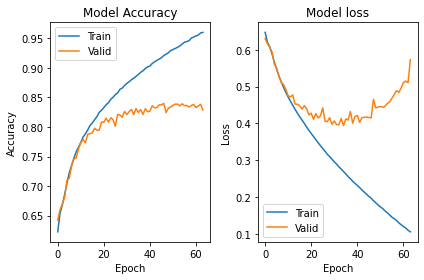

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history["accuracy"])
ax1.plot(history.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

###Prediction on the Test data

In [ ]:
xTest = model.predict(testGen)
yTest = testGen.classes

  1/800 [..............................] - ETA: 1:12

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


800/800 [==============================] - 48s 60ms/step


###Confusion Matrix

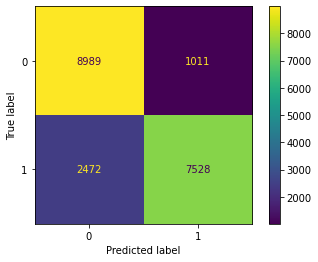

In [ ]:
cm = confusion_matrix(yTest, xTest.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

###Test results

In [ ]:
print(classification_report(yTest, xTest > 0.5))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84     10000
           1       0.88      0.75      0.81     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.82     20000
weighted avg       0.83      0.83      0.82     20000



##Activation relu and added dropouts

From the earlier run we came to conclusion that our model are getting overfitted and to counter that we add dropouts

**Configuration:**
> Activation function: relu, sigmoid

> Cost function: crossentropy

> Optimization function: Adam

In [ ]:
class LeNet2(Sequential):
    def __init__(self, input_shape, nb_classes, opt='adam'):
        super().__init__()

        self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
        self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='relu'))
        self.add(Dropout(0.3))
        self.add(Dense(84, activation='relu'))
        self.add(Dropout(0.3))
        self.add(Dense(nb_classes, activation='sigmoid'))

        self.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model = LeNet2((32,32,1), 1)
model.summary()

Model: "le_net2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6924

###Model training

In [ ]:
history = model.fit_generator(
    trainGen,
    steps_per_epoch = (100000//96),
    validation_data = validGen,
    validation_steps = (20000//96),
    epochs = 40
)

<ipython-input-15-16e40f135953>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/40
1041/1041 [==============================] - 304s 289ms/step - loss: 0.5806 - accuracy: 0.6911 - val_loss: 0.5318 - val_accuracy: 0.7330
Epoch 2/40
1041/1041 [==============================] - 285s 274ms/step - loss: 0.5072 - accuracy: 0.7532 - val_loss: 0.4804 - val_accuracy: 0.7702
Epoch 3/40
1041/1041 [==============================] - 288s 277ms/step - loss: 0.4719 - accuracy: 0.7757 - val_loss: 0.4535 - val_accuracy: 0.7868
Epoch 4/40
1041/1041 [==============================] - 300s 288ms/step - loss: 0.4439 - accuracy: 0.7935 - val_loss: 0.4388 - val_accuracy: 0.7967
Epoch 5/40
1041/1041 [==============================] - 287s 276ms/step - loss: 0.4247 - accuracy: 0.8050 - val_loss: 0.4246 - val_accuracy: 0.8081
Epoch 6/40
1041/1041 [==============================] - 293s 281ms/step - loss: 0.4080 - accuracy: 0.8162 - val_loss: 0.4134 - val_accuracy: 0.8141
Epoch 7/40
1041/1041 [==============================] - 335s 322ms/step - loss: 0.3953 - accuracy: 0.8219 - val_

###Plot on results

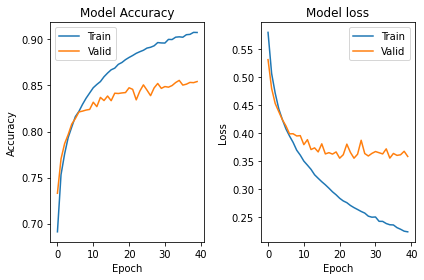

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history["accuracy"])
ax1.plot(history.history["val_accuracy"])
ax1.title.set_text("Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Train", "Valid"])

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.title.set_text("Model loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Train", "Valid"])
plt.tight_layout()
plt.show()

###Prediction on the Test data

In [ ]:
xTest = model.predict(testGen)
yTest = testGen.classes

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


209/209 [==============================] - 44s 209ms/step


In [ ]:
print("ROC-AUC Score:", roc_auc_score(yTest, xTest))
print("AP Score:", average_precision_score(yTest, xTest))

ROC-AUC Score: 0.933484595
AP Score: 0.9301818749737547


###Confusion Matrix

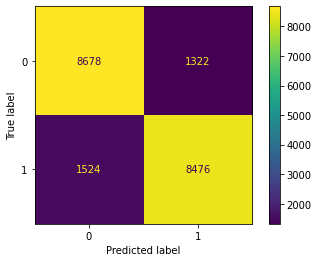

In [ ]:
cm = confusion_matrix(yTest, xTest.round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

###Test results

In [ ]:
print(classification_report(yTest, xTest > 0.5))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     10000
           1       0.87      0.85      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

